In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

from utils import *

%matplotlib inline

In [2]:
data = pd.read_csv('data/data.csv')
data.value = data.value.map(np.log)
data.sample(6)

,date,variable,value
48236,2005-08-02 20:00:00,area_3,4.855874
35848,2004-03-04 16:00:00,area_3,4.322024
12731,2005-06-14 11:00:00,area_1,NaN
46703,2005-05-30 23:00:00,area_3,4.132347
18028,2004-02-06 04:00:00,area_2,5.190404
39362,2004-07-29 02:00:00,area_3,4.132379


In [3]:
data['date']=pd.to_datetime(data['date'])

In [4]:
data = data.set_index(['date','variable'])


In [5]:
data = data.sort_index()

In [6]:
area1 = data.loc[idx[:,'area_1'],:].reset_index(level='variable',drop=True)
area1 = area1.loc[:area1[area1.value.isnull() == False].iloc[-1].name]
area1.value = area1.value.interpolate()

area2 = data.loc[idx[:,'area_2'],:].reset_index(level='variable',drop=True)
area2 = area2.loc[:area2[area2.value.isnull() == False].iloc[-1].name]
area2.value = area2.value.interpolate()

area3 = data.loc[idx[:,'area_3'],:].reset_index(level='variable',drop=True)
area3 = area3.loc[:area3[area3.value.isnull() == False].iloc[-1].name]
area3.value = area3.value.interpolate()

# area1.head(5)

In [7]:
area1_logged = area1['value'].map(np.log)
area1_logged_diffed = area1_logged.diff()

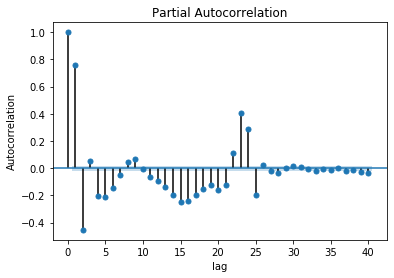

In [8]:
plot_pacf(area1_logged_diffed.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [9]:
#data.loc[idx[:,'area_2'],:].unstack(1).value.plot()

In [10]:
#data.loc[idx[:,'area_1'],:].unstack(1).value.plot()

In [28]:
p = [1]
d = q  = P = D = Q = range(0, 2)   #  <--- all of the paramters between 0 and 2 



S = [24] # <-- let's pretend we have a couple of hypothesis 

In [29]:
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))

In [30]:
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

In [31]:
def get_aic(series_, params):
    # extract the params 
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    # fit a model with those params 
    model = SARIMAX(series_,order=(p, d, q), seasonal_order=(P, D, Q, S),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
    
    # fit the model
    results = model.fit(maxiter=200)
    predictions_best_model = results.get_prediction()
    mep = mean_absolute_percentage_error(series_[1:],np.exp(predictions_best_model.predicted_mean)[1:])
    
    # return the aic 
    return mep

In [32]:
%%time 

aic_scores = {}
params_index = {}

for i in range(len(inputs)):
    try: 
        param_set = inputs[i]
        aic = get_aic(area1_logged, param_set) 
        aic_scores[i] = aic
        params_index[i] = param_set
    
    # this will fail sometimes with impossible parameter combinations. 
    # ... and I'm too lazy to remember what they are. 
    except Exception as e: 
        continue

/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/fc/anaconda3/envs/hckt03/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information w

KeyboardInterrupt: 

In [27]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['aic'] = pd.Series(aic_scores)
temp.sort_values('aic').head()

,p,d,q,P,D,Q,S,aic
7,1,1,1,1,0,0,24,173.402149
3,0,1,1,1,0,0,24,173.402694
5,1,1,0,1,0,0,24,173.404419
1,0,1,0,1,0,0,24,173.412350
6,1,1,1,0,0,0,24,173.415049
